In [172]:
import numpy as np

class DenseLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.zeros((1, output_dim))
        self.input = None
        self.d_weights = None
        self.d_bias = None  

    def forward(self, X):
        self.input = X
        return np.dot(X, self.weights) + self.bias

    def backward(self, d_out, learning_rate):
        self.d_weights = np.dot(self.input.T, d_out)
        self.d_bias = np.sum(d_out, axis=0, keepdims=True)
        d_input = np.dot(d_out, self.weights.T)
        return d_input

In [173]:
class ReLU:
    def forward(self, X):
        self.input = X
        return np.maximum(0, X)

    def backward(self, d_out):
        return d_out * (self.input > 0)

In [174]:
class BatchNormalization:
    def __init__(self, dim, epsilon=1e-5, momentum=0.9):
        self.gamma = np.ones(dim)
        self.beta = np.zeros(dim)
        self.epsilon = epsilon
        self.momentum = momentum
        self.running_mean = np.zeros(dim)
        self.running_var = np.zeros(dim)
        self.input = None

    def forward(self, X, training=True):
        if training:
            self.mean = np.mean(X, axis=0)
            self.var = np.var(X, axis=0)
            self.input = X

            self.X_norm = (X - self.mean) / np.sqrt(self.var + self.epsilon)
            out = self.gamma * self.X_norm + self.beta

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            X_norm = (X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            out = self.gamma * X_norm + self.beta
        
        return out

    def backward(self, d_out, learning_rate):
        N, D = d_out.shape

        X_mu = self.input - self.mean
        std_inv = 1. / np.sqrt(self.var + self.epsilon)

        dX_norm = d_out * self.gamma
        dvar = np.sum(dX_norm * X_mu, axis=0) * -0.5 * std_inv**3
        dmean = np.sum(dX_norm * -std_inv, axis=0) + dvar * np.mean(-2. * X_mu, axis=0)

        dX = (dX_norm * std_inv) + (dvar * 2 * X_mu / N) + (dmean / N)
        self.gamma -= learning_rate * np.sum(d_out * self.X_norm, axis=0)
        self.beta -= learning_rate * np.sum(d_out, axis=0)
        
        return dX


In [175]:
class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate

    def forward(self, X, training=True):
        if training:
            self.mask = np.random.rand(*X.shape) > self.dropout_rate
            return X * self.mask / (1 - self.dropout_rate)
        else:
            return X

    def backward(self, d_out):
        return d_out * self.mask / (1 - self.dropout_rate)


In [176]:
class AdamOptimizer:
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, params, grads):
        self.t += 1
        updated_params = {}

        for key in params:
            if key not in self.m:
                self.m[key] = [np.zeros_like(grads[key][0]),np.zeros_like(grads[key][1])]
                self.v[key] = [np.zeros_like(grads[key][0]),np.zeros_like(grads[key][1])]

            self.m[key][0] = self.beta1 * self.m[key][0] + (1 - self.beta1) * grads[key][0]
            self.m[key][1] = self.beta1 * self.m[key][1] + (1 - self.beta1) * grads[key][1]

            self.v[key][0] = self.beta2 * self.v[key][0] + (1 - self.beta2) * (grads[key][0] ** 2)
            self.v[key][1] = self.beta2 * self.v[key][1] + (1 - self.beta2) * (grads[key][1] ** 2)

            m_hat_weights = self.m[key][0] / (1 - self.beta1 ** self.t)
            m_hat_bias = self.m[key][1] / (1 - self.beta1 ** self.t)
            v_hat_weights = self.v[key][0] / (1 - self.beta2 ** self.t)
            v_hat_bias = self.v[key][1] / (1 - self.beta2 ** self.t)

            updated_params[key] =[params[key][0] - self.learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + self.epsilon),
                                    params[key][1] - self.learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + self.epsilon)]

        return updated_params



In [177]:
class Softmax:
    def forward(self, X):
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output

    def backward(self, d_out):
        return self.output * (d_out - np.sum(d_out * self.output, axis=1, keepdims=True))


In [178]:
class FeedForwardNeuralNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        self.layers = []
        
        # Adding first Dense layer
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(DenseLayer(prev_dim, hidden_dim))
            self.layers.append(BatchNormalization(hidden_dim))
            self.layers.append(ReLU())
            self.layers.append(Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Adding final Dense layer
        self.layers.append(DenseLayer(prev_dim, output_dim))
        self.layers.append(Softmax())

    def forward(self, X, training=True):
        # Forward pass through all layers
        for layer in self.layers:
            if isinstance(layer, (Dropout,BatchNormalization)):
                X = layer.forward(X, training)
            else:
                X = layer.forward(X)
        return X

    def backward(self, d_out, learning_rate):
        # Backward pass through all layers in reverse order
        for layer in reversed(self.layers):
            if isinstance(layer, (DenseLayer, BatchNormalization)):
                d_out = layer.backward(d_out, learning_rate)
            elif isinstance(layer, (ReLU, Dropout, Softmax)):
                d_out = layer.backward(d_out)

    def update_params(self, adam_optimizer):
        # Parameter and gradient dicts
        params = {}
        grads = {}
        
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                params[id(layer)] = [layer.weights,layer.bias]
                grads[id(layer)] = [layer.d_weights,layer.d_bias]
        
        # Updating parameters using Adam optimizer
        updated_params = adam_optimizer.update(params, grads)

        # Updating the layers with the new parameters
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                layer.weights = updated_params[id(layer)][0]
                layer.bias = updated_params[id(layer)][1]


In [179]:
from torchvision import datasets, transforms

# Define transformation
transform = transforms.ToTensor()

# Load the training dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# Load the test dataset separately
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

In [180]:
import tqdm
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix


class Model:
    def __init__(self,input_dim,hidden_dims,output_dim,dropout_rate,learning_rate,batch_size,num_epochs):
        # Hyperparameters
        self.input_dim = input_dim 
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim 
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.batch_size = batch_size 
        self.num_epochs = num_epochs

        # Initialize the fnn
        self.fnn = FeedForwardNeuralNetwork(self.input_dim, self.hidden_dims, self.output_dim, self.dropout_rate)
        self.adam_optimizer = AdamOptimizer(self.learning_rate)

    def fit(self,dataset,history):

        # Split the dataset for training and validation
        train_size = int(0.8 * len(dataset))  #!<-----------------------------------------------------------
        val_size = len(dataset) - train_size
        train_subset, val_subset = random_split(dataset, [train_size, val_size])

        # Create DataLoaders for training and validation subsets
        train_loader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=self.batch_size, shuffle=False)

        # Training loop
        print(self.num_epochs)
        for epoch in range(self.num_epochs):
            epoch_loss = 0
            correct = 0
            total = 0

            for images, labels in tqdm.tqdm(train_loader):
                # Flatten images
                images = images.view(-1, 28 * 28).numpy()
                
                # Forward pass
                outputs = self.fnn.forward(images, training=True)
                
                # One-hot encoding for labels
                one_hot_labels = np.eye(self.output_dim)[labels.numpy()]

                # Compute loss (cross-entropy loss)
                loss = -np.sum(one_hot_labels * np.log(outputs + 1e-8)) / len(labels)
                epoch_loss += loss

                # Backward pass
                d_out = outputs - np.eye(self.output_dim)[labels.numpy()]
                self.fnn.backward(d_out, self.learning_rate)

                # Update parameters
                self.fnn.update_params(self.adam_optimizer)

                # Calculate accuracy
                predictions = np.argmax(outputs, axis=1)
                correct += (predictions == labels.numpy()).sum()
                total += labels.size(0)

            train_accuracy = correct / total
            history['train_loss'].append(epoch_loss / len(train_loader))
            history['train_acc'].append(train_accuracy)

            # Display epoch results
            print("total: ",total,"correct: ",correct)
            epoch_accuracy = correct / total
            print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss/ len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}')


            # Testing phase
            all_predictions = []
            all_true_labels = []

            correct = 0
            total = 0
            epoch_loss = 0

            for images, labels in val_loader:
                # Flatten images
                images = images.view(-1, 28 * 28).numpy()

                # Forward pass (inference mode)
                outputs = self.fnn.forward(images, training=False)
                predictions = np.argmax(outputs, axis=1)

                # One-hot encoding for labels
                one_hot_labels = np.eye(self.output_dim)[labels.numpy()]

                # Compute loss (cross-entropy loss)
                loss = -np.sum(one_hot_labels * np.log(outputs + 1e-8)) / len(labels)
                #print(len(labels))
                epoch_loss += loss

                # Collect results
                all_predictions.extend(predictions)
                all_true_labels.extend(labels.numpy())

                # Calculate accuracy
                correct += (predictions == labels.numpy()).sum()
                total += labels.size(0)

            # Calculate accuracy using sklearn
            accuracy = accuracy_score(all_true_labels, all_predictions)
            print(f'Validation Accuracy: {accuracy:.4f}')

            val_accuracy = correct / total
            val_f1 = f1_score(all_true_labels, all_predictions, average='macro')
            val_loss = epoch_loss / len(val_loader)
            history['val_loss'].append(val_loss)
            print(f'Validation loss: {val_loss:.4f}')
            history['val_acc'].append(val_accuracy)
            history['val_f1'].append(val_f1)
            print(f'Validation Macro F1: {val_f1:.4f}')

        return self.fnn

In [181]:
def Test(model,data):
    all_predictions = []
    all_labels = []
    for images, labels in data:
        # Flatten the images
        images = images.view(images.size(0), -1).numpy()

        # Forward pass through the loaded model
        outputs = model.forward(images)

        # Get the predicted class (highest probability)
        predictions = np.argmax(outputs, axis=1)

        # Collect predictions and true labels for accuracy computation
        all_predictions.extend(predictions)
        all_labels.extend(labels.numpy())

    # Step 4: Evaluate the model
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [182]:
input_dim = 28 * 28  # Image size (28x28)
output_dim = 10  # Number of classes (0-9)
dropout_rate = 0.2
batch_size = 64
num_epochs = 10

hidden_dims = [64,32]  # Hidden layers
learning_rate = 0.001

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}
model1 = Model(input_dim,hidden_dims,output_dim,dropout_rate,learning_rate,batch_size,num_epochs)
model = model1.fit(train_dataset,history)

10


  0%|          | 0/750 [00:00<?, ?it/s]

100%|██████████| 750/750 [00:07<00:00, 95.02it/s] 


total:  48000 correct:  36229
Epoch [1/10], Loss: 0.8982, Accuracy: 0.7548
Validation Accuracy: 0.8474
Validation loss: 0.4716
Validation Macro F1: 0.8460


100%|██████████| 750/750 [00:07<00:00, 94.65it/s] 


total:  48000 correct:  39749
Epoch [2/10], Loss: 0.5447, Accuracy: 0.8281
Validation Accuracy: 0.8559
Validation loss: 0.4277
Validation Macro F1: 0.8553


100%|██████████| 750/750 [00:08<00:00, 87.54it/s] 


total:  48000 correct:  40424
Epoch [3/10], Loss: 0.5002, Accuracy: 0.8422
Validation Accuracy: 0.8572
Validation loss: 0.4186
Validation Macro F1: 0.8528


100%|██████████| 750/750 [00:08<00:00, 88.59it/s] 


total:  48000 correct:  40803
Epoch [4/10], Loss: 0.4676, Accuracy: 0.8501
Validation Accuracy: 0.8672
Validation loss: 0.3934
Validation Macro F1: 0.8650


100%|██████████| 750/750 [00:07<00:00, 97.49it/s] 


total:  48000 correct:  41000
Epoch [5/10], Loss: 0.4514, Accuracy: 0.8542
Validation Accuracy: 0.8670
Validation loss: 0.3809
Validation Macro F1: 0.8679


100%|██████████| 750/750 [00:07<00:00, 97.78it/s] 


total:  48000 correct:  41244
Epoch [6/10], Loss: 0.4374, Accuracy: 0.8592
Validation Accuracy: 0.8752
Validation loss: 0.3596
Validation Macro F1: 0.8741


100%|██████████| 750/750 [00:07<00:00, 98.47it/s] 


total:  48000 correct:  41377
Epoch [7/10], Loss: 0.4287, Accuracy: 0.8620
Validation Accuracy: 0.8776
Validation loss: 0.3572
Validation Macro F1: 0.8765


100%|██████████| 750/750 [00:07<00:00, 95.75it/s] 


total:  48000 correct:  41672
Epoch [8/10], Loss: 0.4118, Accuracy: 0.8682
Validation Accuracy: 0.8749
Validation loss: 0.3635
Validation Macro F1: 0.8730


100%|██████████| 750/750 [00:07<00:00, 99.34it/s] 


total:  48000 correct:  41766
Epoch [9/10], Loss: 0.4089, Accuracy: 0.8701
Validation Accuracy: 0.8814
Validation loss: 0.3564
Validation Macro F1: 0.8795


100%|██████████| 750/750 [00:07<00:00, 93.95it/s] 


total:  48000 correct:  41772
Epoch [10/10], Loss: 0.4073, Accuracy: 0.8702
Validation Accuracy: 0.8725
Validation loss: 0.3822
Validation Macro F1: 0.8723


In [183]:
# DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
Test(model,test_loader)

Test Accuracy: 84.72%


{'train_loss': [0.8981508019185771, 0.5446612169951727, 0.5001593175779675, 0.46759666900998764, 0.4513614724763348, 0.4373648795178592, 0.42872363761121157, 0.4118104385284161, 0.40888252145017284, 0.4073223659913751], 'val_loss': [0.471643396851367, 0.4277096762492122, 0.41861094778791846, 0.39339718590177747, 0.3808682355377441, 0.35955926557190493, 0.3572374004180363, 0.36345010169967834, 0.3563599544099528, 0.38220553696201764], 'train_acc': [0.7547708333333333, 0.8281041666666666, 0.8421666666666666, 0.8500625, 0.8541666666666666, 0.85925, 0.8620208333333333, 0.8681666666666666, 0.870125, 0.87025], 'val_acc': [0.8474166666666667, 0.8559166666666667, 0.8571666666666666, 0.8671666666666666, 0.867, 0.87525, 0.8775833333333334, 0.8749166666666667, 0.8814166666666666, 0.8725], 'val_f1': [0.8459712008312351, 0.8552931433674009, 0.8527901312059691, 0.8649543658957869, 0.8678734727432591, 0.8741411743459138, 0.8765250790261483, 0.873044477438001, 0.8795439845883098, 0.8722863896483968]}


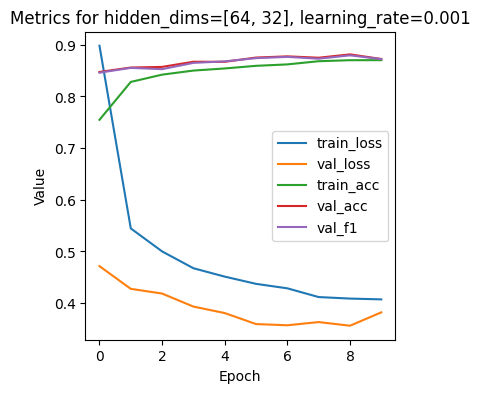

In [184]:
print(history)

import matplotlib.pyplot as plt
# Function to plot training history
def plot_metrics(history, title="Training and Validation Metrics"):
    plt.figure(figsize=(4, 4))
    for metric in ['train_loss', 'val_loss', 'train_acc', 'val_acc', 'val_f1']:
        plt.plot(history[metric], label=metric)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

plot_metrics(history, title=f"Metrics for hidden_dims={hidden_dims}, learning_rate={learning_rate}")

In [185]:
"""
import torch.AdamOptimizer
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import tqdm

# Split the dataset for training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Define DataLoaders
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model parameters
input_dim = 28 * 28  # Image size (28x28)
hidden_dims_options = [[128, 64], [64, 32], [32, 16]]  # Different hidden layer configurations
output_dim = 10  # Number of classes
dropout_rate = 0.2
num_epochs = 10
learning_rates = [0.005, 0.001, 0.0005, 0.0001]

# Define Feed-Forward Neural Network class
class FeedForwardNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        super(FeedForwardNeuralNetwork, self).__init__()
        layers = []
        current_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = h_dim
        layers.append(nn.Linear(current_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Training and Evaluation Function
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in tqdm.tqdm(train_loader):
            images = images.view(-1, input_dim)  # Flatten images
            labels = labels
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_predictions, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(-1, input_dim)
                labels = labels

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_accuracy = correct / total
        val_f1 = f1_score(all_labels, all_predictions, average='macro')
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_accuracy)
        history['val_f1'].append(val_f1)

        # Print metrics for each epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')

    return history

print(history)
# Function to plot training history
def plot_metrics(history, title="Training and Validation Metrics"):
    plt.figure(figsize=(4, 4))
    for metric in ['train_loss', 'val_loss', 'train_acc', 'val_acc', 'val_f1']:
        plt.plot(history[metric], label=metric)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

# Test Function
def test_model(model, test_loader):
    model.eval()
    all_predictions, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, input_dim)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy and F1 score
    test_accuracy = accuracy_score(all_labels, all_predictions)
    test_f1 = f1_score(all_labels, all_predictions, average='macro')
    print(f'Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}')

    # Confusion Matrix
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_predictions))

# Experiment with different configurations
best_f1 = 0
best_model = None
criterion = nn.CrossEntropyLoss()

for lr in learning_rates:
    for hidden_dims in hidden_dims_options:
        # Initialize model, optimizer
        model = FeedForwardNeuralNetwork(input_dim, hidden_dims, output_dim, dropout_rate)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Train and evaluate
        print(f"\nTraining model with hidden_dims={hidden_dims} and learning_rate={lr}")
        history = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs)
        
        # Plot metrics for this configuration
        plot_metrics(history, title=f"Metrics for hidden_dims={hidden_dims}, learning_rate={lr}")
        
        # Check if this model is the best based on validation F1
        max_val_f1 = max(history['val_f1'])
        if max_val_f1 > best_f1:
            best_f1 = max_val_f1
            best_model = model

# Test the best model
print("\nTesting the best model:")
test_model(best_model, test_loader)
"""

'\nimport torch.AdamOptimizer\nimport torch.nn as nn\nimport torch.optim as optim\nimport numpy as np\nfrom torchvision import datasets, transforms\nfrom torch.utils.data import DataLoader, random_split\nfrom sklearn.metrics import f1_score, accuracy_score, confusion_matrix\nimport matplotlib.pyplot as plt\nimport tqdm\n\n# Split the dataset for training and validation\ntrain_size = int(0.8 * len(train_dataset))\nval_size = len(train_dataset) - train_size\ntrain_subset, val_subset = random_split(train_dataset, [train_size, val_size])\n\n# Define DataLoaders\nbatch_size = 64\ntrain_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)\nval_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)\ntest_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)\n\n# Model parameters\ninput_dim = 28 * 28  # Image size (28x28)\nhidden_dims_options = [[128, 64], [64, 32], [32, 16]]  # Different hidden layer configurations\noutput_dim = 10  # Number 

In [186]:
import pickle

# Save the trained model to a file
with open('fashion_mnist_model.pkl', 'wb') as file:
    pickle.dump(model, file)
print("Model saved successfully!")


Model saved successfully!


In [187]:
# Load the model from the file
with open('fashion_mnist_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully!")


Model loaded successfully!


In [188]:
Test(loaded_model,test_loader)

Test Accuracy: 84.90%
